In [ ]:
!pip install river scikit-learn

# Batch learning

In [706]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, f1_score

In [707]:
import seaborn as sns

df = sns.load_dataset("penguins")


In [708]:
df 

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [709]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [710]:
df.island.value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

In [711]:
target = 'species'
y = df[target]
X = df.drop(target, axis=1)

In [712]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [713]:
numeric_features = X_train.select_dtypes(exclude=object).columns
categorical_features = X_train.select_dtypes(include=object).columns

In [714]:
numeric_transformer = SimpleImputer()
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder()
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [715]:
X_train.iloc[256]

island               Biscoe
bill_length_mm         49.3
bill_depth_mm          15.7
flipper_length_mm     217.0
body_mass_g          5850.0
sex                    Male
Name: 235, dtype: object

In [716]:
preprocessor.fit_transform(X_train)[256]

array([4.93e+01, 1.57e+01, 2.17e+02, 5.85e+03, 1.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 1.00e+00])

In [717]:
sklearn_clf = make_pipeline(preprocessor, DecisionTreeClassifier())


In [718]:
sklearn_clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [719]:
y_pred = sklearn_clf.predict(X_test)

In [720]:
f1_score(y_test, y_pred, average='micro')

0.9767441860465116

In [721]:
confusion_matrix(y_test, y_pred)

array([[40,  2,  0],
       [ 0, 14,  0],
       [ 0,  0, 30]])

# Online learning

## Get started

In [722]:
from river import (
    stream,
    compose,
    preprocessing,
    evaluate,
    metrics,
    tree,
    imblearn,
    stats,
)
import numbers


In [723]:
for xi, yi in stream.iter_pandas(X, y):
    pass

In [724]:
xi 

{'island': 'Biscoe',
 'bill_length_mm': 49.9,
 'bill_depth_mm': 16.1,
 'flipper_length_mm': 213.0,
 'body_mass_g': 5400.0,
 'sex': 'Male'}

In [725]:
X_sample = [{"age": 10}, {"age": 30}, {"age": None}, {"age": 2}]
mean = stats.Mean()
imputer = preprocessing.StatImputer(("age", mean))
for xi_sample in X_sample:
    imputer.learn_one(xi_sample)
    print(imputer.transform_one(xi_sample))

{'age': 10}
{'age': 30}
{'age': 20.0}
{'age': 2}


In [726]:
cat = (
    compose.SelectType(object)
    | preprocessing.StatImputer()
    | preprocessing.OneHotEncoder(sparse=True)
)
num = compose.SelectType(numbers.Number) | preprocessing.StatImputer()


In [749]:
preprocessor = num + cat
preprocessor.learn_one(xi)
xi_transformed = preprocessor.transform_one(xi)
xi_transformed


{'island_Biscoe': 1,
 'bill_length_mm_49.9': 1,
 'bill_depth_mm_16.1': 1,
 'flipper_length_mm_213.0': 1,
 'body_mass_g_5400.0': 1,
 'sex_Male': 1,
 'bill_length_mm': 49.9,
 'bill_depth_mm': 16.1,
 'flipper_length_mm': 213.0,
 'body_mass_g': 5400.0}

In [737]:
clf = tree.HoeffdingTreeClassifier()
clf.summary

{'n_nodes': None,
 'n_branches': None,
 'n_leaves': None,
 'n_active_leaves': 0,
 'n_inactive_leaves': 0,
 'height': 0,
 'total_observed_weight': 0.0}

In [730]:
def get_pipeline():
    cat = (
        compose.SelectType(object)
        | preprocessing.StatImputer()
        | preprocessing.OneHotEncoder(sparse=True)
    )
    num = compose.SelectType(numbers.Number) | preprocessing.StatImputer()
    processor = num + cat
    classifier = tree.HoeffdingTreeClassifier()
    return processor | classifier


In [731]:
def train(X, y):
    pipeline = get_pipeline()

    # Initialize metrics 
    f1_score = metrics.MicroF1()
    cm = metrics.ConfusionMatrix()

    f1_scores = []

    # Iterate over the dataset
    for xi, yi in stream.iter_pandas(X, y, shuffle=True, seed=1):
        # Predict the new sample
        yi_pred = pipeline.predict_one(xi)

        # Get the score
        if yi_pred is not None:
            f1_score.update(yi, yi_pred)
            f1_scores.append(f1_score.get() * 100)
            cm.update(yi, yi_pred)

        # Train the model with the new sample
        pipeline.learn_one(xi, yi)

    return f1_scores, cm, pipeline


f1_scores, cm, pipeline = train(X, y)


In [732]:
pipeline 

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        <class 'numbers.Number'>
      ),
      StatImputer (
        imputers=()
      )
    ),
    Pipeline (
      Select (
        <class 'object'>
      ),
      StatImputer (
        imputers=()
      ),
      OneHotEncoder (
        sparse=True
      )
    )
  ),
  HoeffdingTreeClassifier (
    grace_period=200
    max_depth=inf
    split_criterion="info_gain"
    delta=1e-07
    tau=0.05
    leaf_prediction="nba"
    nb_threshold=0
    nominal_attributes=None
    splitter=GaussianSplitter (
      n_splits=10
    )
    binary_split=False
    max_size=100.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  )
)

In [733]:
pipeline.steps['HoeffdingTreeClassifier'].summary

{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 344.0}

In [ ]:
cm 

            Adelie   Chinstrap   Gentoo  
   Adelie      143           8        0  
Chinstrap       44          22        2  
   Gentoo       66           1       57  

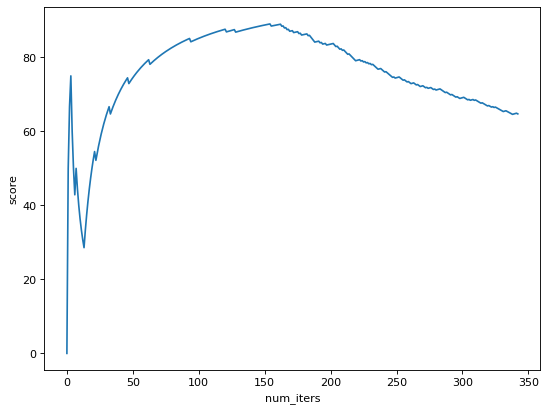

In [ ]:
import matplotlib.pyplot as plt


def plot(scores: list):
    plt.figure(figsize=(8, 6), dpi=80)
    iters = range(len(scores))
    ax = sns.lineplot(x=iters, y=scores)
    ax.set(xlabel="num_iters", ylabel="score")
    plt.show()


plot(f1_scores)


In [ ]:
pipeline = get_pipeline()

metric = metrics.MicroF1()

evaluate.progressive_val_score(
    dataset=stream.iter_pandas(X, y, shuffle=True, seed=1),
    model=pipeline,
    metric=metric,
    print_every=50,
)


[50] MicroF1: 73.47%
[100] MicroF1: 84.85%
[150] MicroF1: 88.59%
[200] MicroF1: 83.42%
[250] MicroF1: 74.70%
[300] MicroF1: 68.90%


MicroF1: 64.72%

In [ ]:
y.value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

### Deal with Unbalanced Data

In [743]:
def get_pipeline():
    cat = (
        compose.SelectType(object)
        | preprocessing.StatImputer()
        | preprocessing.OneHotEncoder(sparse=True)
    )
    num = compose.SelectType(numbers.Number) | preprocessing.StatImputer()
    classifier = tree.HoeffdingTreeClassifier()
    sampler = imblearn.RandomSampler(
        classifier=classifier,
        desired_dist={"Adelie": 0.1, "Gentoo": 0.4, "Chinstrap": 0.5},
        seed=2,
    )
    return (num + cat) | sampler


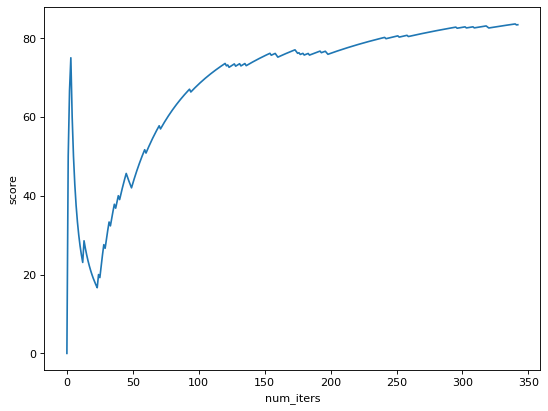

In [741]:
f1_scores, cm, pipeline= train(X, y)
plot(f1_scores)

In [ ]:
cm 

            Adelie   Chinstrap   Gentoo  
   Adelie      111          37        3  
Chinstrap        5          62        1  
   Gentoo        5           6      113  

In [ ]:
pipeline = get_pipeline()

metric = metrics.MicroF1()

evaluate.progressive_val_score(
    dataset=stream.iter_pandas(X, y, shuffle=True, seed=1),
    model=pipeline,
    metric=metric,
    print_every=50,
)


[50] MicroF1: 42.86%
[100] MicroF1: 67.68%
[150] MicroF1: 75.17%
[200] MicroF1: 75.88%
[250] MicroF1: 80.32%
[300] MicroF1: 82.61%


MicroF1: 83.38%